In [1]:
import cell2cell as c2c

import numpy as np
import pandas as pd

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [2]:
data_folder = '../../data/'

In [ ]:
import os

output_folder = '../../results/Benchmarking/'
if not os.path.isdir(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
files = dict()
files['rnaseq'] = data_folder + '/RNA-Seq/Celegans_RNASeqData_Cell.xlsx'
files['metadata'] = data_folder + '/RNA-Seq/Celegans_cell_metadata.tsv'
files['ppi'] = data_folder + '/PPI-Networks/Celegans-Curated-LR-pairs.xlsx'
files['output_folder'] = output_folder

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [4]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Metadata columns**

- <font color="green">'sample_col'</font> is the name of the column containing the sample or cell names in RNA-seq data (equivalent to the columns in rnaseq_data).
- <font color="green">'group_col'</font> is the name of the column containing the labels for the respective samples or cells in order to group/color them in downstream analyses.

In [5]:
meta_setup = dict()
meta_setup['sample_col'] = '#SampleID'
meta_setup['group_col'] = 'Groups'

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [6]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['Ligand_WB', 'Receptor_WB']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. 
    - 'constant_value'
    - 'local_percentile'
    - 'global_percentile'
    - None
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [7]:
# cutoff_setup = dict()
# cutoff_setup['type'] = 'constant_value'
# cutoff_setup['parameter'] = 10 # TPM

**General Analysis setups**

- <font color="green">'communication_score'</font> is the type of communication score used to detect active pathways between each pair of cell. It can be:
    - 'expression_thresholding'
    - 'expression_product'
    - 'expression_correlation'
    - 'differential_combinations'
- <font color="green">'cci_score'</font> is the scoring function to aggregate the communication scores. It can be:
    - 'bray_curtis'
    - 'jaccard'
    - 'count'
- <font color="green">'cci_type'</font> is the type of interaction between two cells. If it is undirected, ligand and receptor are considered from both cells. If it is directed, ligands from one cell and receptors from the other are considered separately with respect to ligands from the second cell and receptor from the first one. So, it can be:
    - 'undirected'
    - 'directed

In [8]:
analysis_setup = dict()
analysis_setup['communication_score'] = 'expression_product'
analysis_setup['cci_score'] = 'icellnet'
analysis_setup['cci_type'] = 'undirected'

# Load Data

**RNA-seq**

In [9]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from ..//ICELLNET/Celegans_RNASeqData_Cell.xlsx
..//ICELLNET/Celegans_RNASeqData_Cell.xlsx was correctly loaded


In [10]:
rnaseq_data = rnaseq_data.applymap(lambda x: np.log2(x+1))

**Metadata for cell types**

In [11]:
meta = c2c.io.load_metadata(metadata_file=files['metadata'],
                            cell_labels=rnaseq_data.columns,
                            format='auto')

..//ICELLNET/Celegans_cell_metadata.tsv was correctly loaded


**PPI network**

In [12]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')

Opening PPI datasets from https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs/blob/master/Others/Celegans-2020-Armingol-LR-pairs.xlsx?raw=true
https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs/blob/master/Others/Celegans-2020-Armingol-LR-pairs.xlsx?raw=true was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [13]:
ppi_data.shape

(245, 3)

# Labels of LR pairs

In [14]:
lr_pairs = c2c.io.load_table(files['ppi'])

https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs/blob/master/Others/Celegans-2020-Armingol-LR-pairs.xlsx?raw=true was correctly loaded


In [15]:
lr_pairs.head()

,Ligand_WB,Receptor_WB,Ligand_symbol,Receptor_symbol,LR Function,L Function,R Function,Ligand_desc,Receptor_desc
0,WBGene00000182,WBGene00004040,arf-1.2,pld-1,Cell adhesion,ADP-ribosylation factor 1,Phospholipase D2,Is an ortholog of human ARF1 (ADP ribosylation...,Is an ortholog of human PLD2 (phospholipase D2...
1,WBGene00000903,WBGene00004860,daf-7,sma-6,TGF-B signaling,GDF11,BMPRIB,Is an ortholog of human GDF11 (growth differen...,Is an ortholog of human BMPR1A (bone morphogen...
2,WBGene00005647,WBGene00008779,srp-6,F14B4.1,Wnt signaling,Serpin family (Blocks wnt signaling),Wnt-Receptor,Is an ortholog of human SERPINB10 (serpin fami...,Is predicted to have Wnt-activated receptor ac...
3,WBGene00000074,WBGene00003930,adm-2,pat-3,Cell adhesion,ADAM,Integrin,Is an ortholog of several human genes includin...,Is an ortholog of human ITGB1 (integrin subuni...
4,WBGene00000074,WBGene00003929,adm-2,pat-2,Cell adhesion,ADAM,Integrin,Is an ortholog of several human genes includin...,Is an ortholog of human ITGA5 (integrin subuni...


In [16]:
lr_genes = list(set(lr_pairs['Ligand_WB'].unique()).union(set(lr_pairs['Receptor_WB'].unique())))

In [17]:
len(lr_genes)

190

In [18]:
labels_dict = dict()
for pair in lr_pairs.iterrows():
    original = (pair[1]['Ligand_WB'], pair[1]['Receptor_WB'])
    new = pair[1]['Ligand_symbol']+' / '+pair[1]['Receptor_symbol']
    labels_dict[original] = new 

# Run Analysis

### Cells to include

In [19]:
excluded_cells = ['Distal_tip_cells',
                  'Sex_myoblasts',
                  'Socket_cells',
                  'Vulval_precursors',
                  'flp-1(+)_interneurons']

In [20]:
included_cells = list((set(rnaseq_data.columns)) - set(excluded_cells))

In [21]:
rnaseq_df = rnaseq_data.loc[lr_genes, included_cells]

### Compute Cell-Cell Interactions

In [22]:
if analysis_setup['cci_type'] == 'undirected':
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=ppi_data, verbose=False)
    ref_ppi = ppi_data
else:
    bi_ppi_data = ppi_data.copy()
    ref_ppi = None

In [23]:
# Base scores
interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                              ppi_data=bi_ppi_data,
                                              gene_cutoffs=None,
                                              communication_score=analysis_setup['communication_score'],
                                              cci_score=analysis_setup['cci_score'],
                                              cci_type=analysis_setup['cci_type'],
                                              verbose=False)

# Compute interactions
interaction_space.compute_pairwise_cci_scores(use_ppi_score=False, verbose=False)
cci_matrix = interaction_space.interaction_elements['cci_matrix'].copy()

# Base scores
base_scores = interaction_space.interaction_elements['cci_matrix']

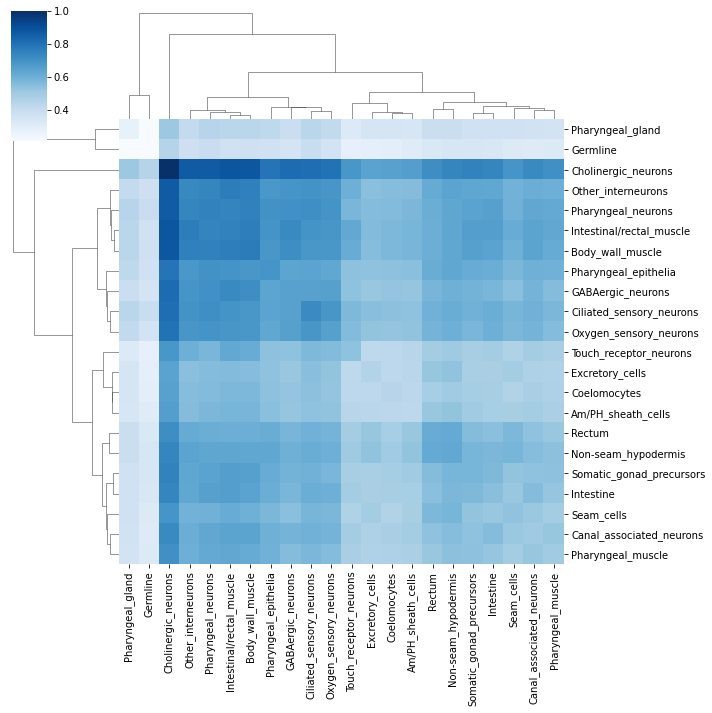

In [24]:
norm_base = base_scores / base_scores.max().max()

sns.clustermap(norm_base, cmap='Blues')

In [25]:
base_scores.to_csv(data_folder + '/Benchmarking/CCI-Matrix-ICELLNET.csv')
base_scores.to_csv(output_folder + 'CCI-Matrix-ICELLNET.csv')